In [38]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os
from sklearn.cluster import KMeans
import pickle
import pandas as pd

In [2]:
coco_images_dir = "coco128/images/train2017/"

In [6]:
def show_image(img, cmap=None):
    plt.figure(figsize=(15, 9))
    img_to_show = img
    if img.ndim == 3:
        img_to_show = img[:,:,::-1]
    elif cmap is None:
        cmap = "gray"

    if cmap:
        plt.imshow(img_to_show, cmap=cmap)
    else:
        plt.imshow(img_to_show)

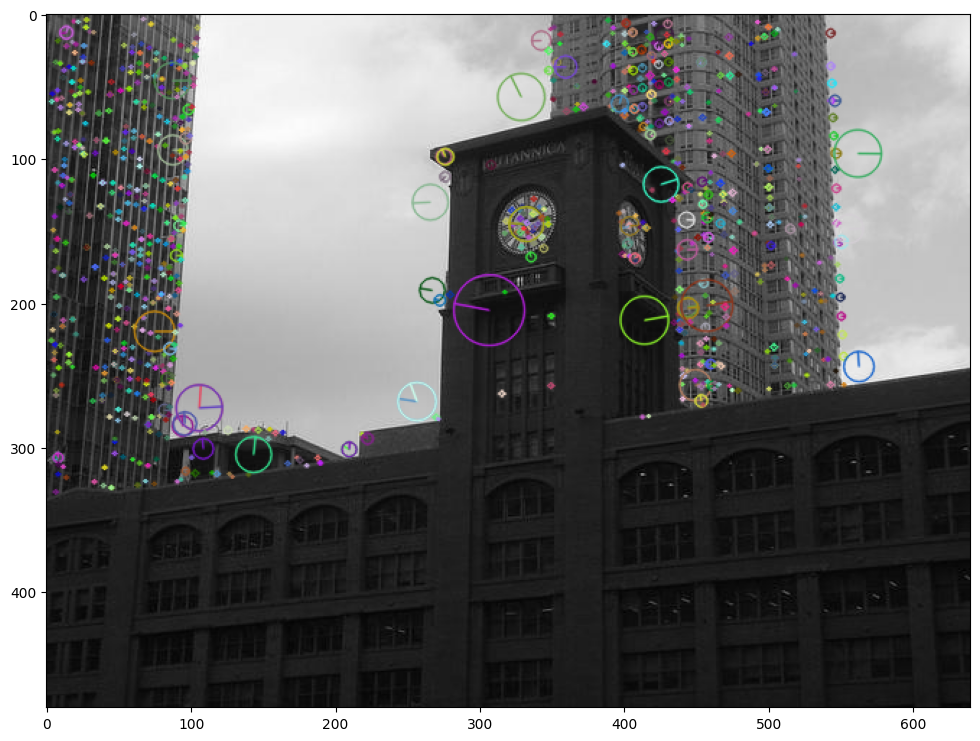

In [14]:
test_path = "000000000626.jpg"
test_path = os.path.join(coco_images_dir, test_path)
test_img = cv.imread(test_path)
gray_img = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp, descriptors = sift.detectAndCompute(gray_img, None)
img = cv.drawKeypoints(gray_img, kp, test_img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_image(img)

In [15]:
descriptors

array([[  0.,   1.,   2., ...,  67.,   1.,   0.],
       [133.,  10.,   0., ...,   0.,   0.,   0.],
       [117.,  24.,   1., ...,   0.,   0.,   1.],
       ...,
       [ 93.,   9.,   1., ...,   1.,  16.,   1.],
       [ 57.,   7.,   0., ...,   0.,   4.,   0.],
       [ 30.,   6.,   1., ...,   1.,   0.,   0.]], dtype=float32)

In [16]:
sift = cv.SIFT_create()

# TODO: fix typo
def get_image_descriptros(gray):
    _, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

In [17]:
def get_descriptors_from_dir(dir):
    descriptors = []
    for filename in os.listdir(dir):
        image_path = os.path.join(dir, filename)
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        image_descriptors = get_image_descriptros(image)
        for i in range(image_descriptors.shape[0]):
            descriptors.append(image_descriptors[i])

    return np.array(descriptors)

In [18]:
descriptors = get_descriptors_from_dir(coco_images_dir)
descriptors

array([[18., 24., 10., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  3.],
       [ 7., 13., 18., ...,  0.,  0.,  2.],
       ...,
       [ 0.,  0.,  0., ...,  6.,  1.,  2.],
       [41.,  6.,  0., ...,  3.,  0.,  0.],
       [30., 12.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [19]:
descriptors.shape

(185453, 128)

## Обучаем модель K-Means

In [31]:
n_clusters = 512

In [22]:
kmeans = KMeans(n_clusters=512, random_state=42, n_init='auto')
kmeans.fit(descriptors)

KMeans(n_clusters=512, n_init='auto', random_state=42)

In [27]:
def save_model_to(model, filename='kmeans.pickle'):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

In [29]:
def load_model_from(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)

    return model

In [28]:
save_model_to(kmeans, 'kmeans.pickle')

## Функция для векторизации изображения

In [32]:
def get_normalized_hist(clusters):
    hist_data = np.zeros((n_clusters))
    for cluster in clusters:
        hist_data[cluster] += 1

    hist_data /= clusters.shape[0]

    return hist_data

In [53]:
def vectorize_image_from_file(model, filename):
    gray_img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    descriptors = get_image_descriptros(gray_img)
    if descriptors.ndim == 1:
        descriptors = descriptors.reshape(1, -1)
    clusters = model.predict(descriptors)
    hist_data = get_normalized_hist(clusters)
    return hist_data

In [54]:
pascal_dir = "pascal"
test_path = "2007_000027.jpg"
test_path = os.path.join(pascal_dir, test_path)
hist_data = vectorize_image_from_file(kmeans, test_path)

<BarContainer object of 512 artists>

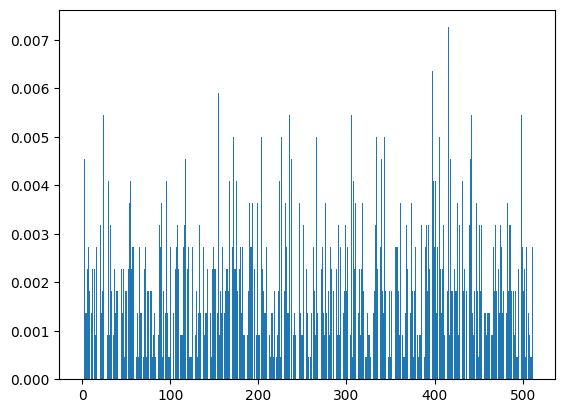

In [55]:
plt.bar(np.arange(n_clusters), hist_data)

In [56]:
np.sum(hist_data)

0.9999999999999999

In [57]:
df = pd.DataFrame(columns=["image_path", "vector"])

In [58]:
df.loc[0] = [test_path, hist_data]
df

,image_path,vector
0,pascal\2007_000027.jpg,"[0.003631411711302769, 0.0018157058556513845, ..."


In [59]:
df["vector"]

0    [0.003631411711302769, 0.0018157058556513845, ...
Name: vector, dtype: object

In [60]:
def fill_df(model, images_dir):
    data = pd.DataFrame(columns=["image_path", "vector"])
    for i, filename in enumerate(os.listdir(images_dir)):
        image_path = os.path.join(images_dir, filename)
        hist_data = vectorize_image_from_file(model, image_path)
        data.loc[i] = [image_path, hist_data]

    return data

In [61]:
data = fill_df(kmeans, pascal_dir)
data

AttributeError: 'NoneType' object has no attribute 'ndim'